In [2]:
from utilities.data_functions import col_to_edge_list, chromatic_numbers
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import WangLoss, PottsLoss, count_collisions, get_bad_edges
from utilities.helpers import get_device

device = get_device()
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4090


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = self.W(out)
        return out


class GraphConvolutionNMP(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.5):
        super().__init__()
        self.W_self = nn.Linear(in_features, out_features)
        self.W_neighbor = nn.Linear(in_features, out_features)
        self.alpha = nn.Parameter(torch.tensor(alpha))
        nn.init.uniform_(self.W_self.weight, 0, 1)
        nn.init.uniform_(self.W_neighbor.weight, 0, 1)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        deg = torch.sum(adj, dim=1)
        deg = torch.where(deg == 0, 1, deg)
        out /= deg.view(-1, 1)
        out = self.W_self(x) - self.alpha*self.W_neighbor(out) 
        return out


class ColorGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(hidden_dim, hidden_dim))

        self.layers.append(GraphConvolution(hidden_dim, output_dim))

        self.adj_normalized = None

    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
            # Apply activation and dropout for all layers except the last one
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.softmax(x, dim=1)
        return x

    def _make_adj(self, edge_index):
        # Create the adjacency matrix from an edge index
        adj = to_dense_adj(edge_index).squeeze(0)

        # Add self-loops and normalize the adjacency matrix
        # adj = adj + torch.eye(adj.size(0)).to(adj.device)
        # D = torch.diag(torch.sum(adj, dim=1) ** (-0.5))
        # self.adj_normalized = torch.matmul(torch.matmul(D, adj), D)
        self.adj_normalized = adj
        self.adj_normalized.to(edge_index.device)

        
class ColorNMP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolutionNMP(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolutionNMP(hidden_dim, hidden_dim))

        self.layers.append(GraphConvolutionNMP(hidden_dim, output_dim))

        self.adj_normalized = None

    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
            # Apply activation and dropout for all layers except the last one
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.softmax(x, dim=1)
        return x

    def _make_adj(self, edge_index):
        # Create the adjacency matrix from an edge index
        adj = to_dense_adj(edge_index).squeeze(0)

        # Add self-loops and normalize the adjacency matrix
        # adj = adj + torch.eye(adj.size(0)).to(adj.device)
        # D = torch.diag(torch.sum(adj, dim=1) ** (-0.5))
        # self.adj_normalized = torch.matmul(torch.matmul(D, adj), D)
        self.adj_normalized = adj
        self.adj_normalized.to(edge_index.device)


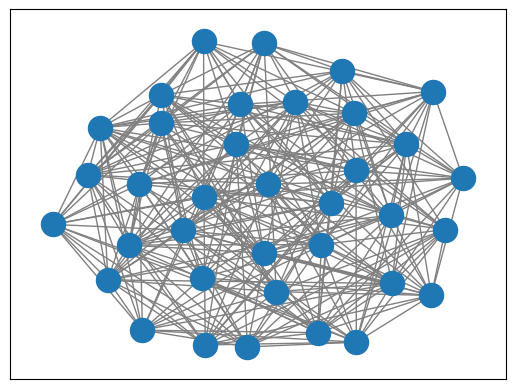

In [9]:
# Load and plot the graph

graph = 'queen6_6.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [39]:
import pandas as pd
from tqdm.notebook import tqdm

# Run the graph model
best_coloring = None
fewest_collisions = 10e5
results = []
cols = ['input_dim', 'hidden_dim', 'dropout', 'use_embedding', 'alternate_embedding', 'lr', 'collisions']
patience = 1000

for in_dim in tqdm([4, 8, 16, 32, 64, 128], desc='in_dim'):
    for hid_dim in tqdm([4, 8, 16, 32, 64, 128], desc='hid_dim', leave=False):
        for dropout in tqdm([0.1, 0.2, 0.3, 0.4, 0.5], desc='dropout', leave=False):
            for use_embedding in tqdm([True, False], desc='use_embedding', leave=False):
                for alternate_embedding in tqdm([True, False], desc='alternate_embedding', leave=False):
                    for lr in tqdm([1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2], desc='lr', leave=False):
                        input_dim = in_dim
                        hidden_dim = hid_dim
                        output_dim = chromatic_numbers[graph]
                        num_layers = 1
                        epochs = 100000

                        model = ColorGCN(input_dim, hidden_dim, output_dim, num_layers, dropout=dropout).to(device)
                        edge_index = edge_list.to(device)
                        if use_embedding:
                            embeddings = nn.Embedding(n, input_dim).to(device)
                            graph_nodes = torch.arange(n).long().to(device)
                        else:
                            graph_rep = torch.randn((n, input_dim)).to(device)
                        if use_embedding:
                            optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
                        else:
                            optimizer = optim.Adam(model.parameters(), lr=lr)
                        loss_fn = PottsLoss(edge_index)
                        # loss_fn = WangLoss(edge_index, lam=.02)

                        prev_loss = 10e5
                        last_improvement = 0
                        for i in range(epochs):
                            if last_improvement > patience:
                                break
                            if use_embedding and alternate_embedding:
                                if i % 1000 == 0:
                                    for param in embeddings.parameters():
                                        param.requires_grad = False
                                    for param in model.parameters():
                                        param.requires_grad = True
                                elif (i + 700) % 1000 == 0:
                                    for param in embeddings.parameters():
                                        param.requires_grad = True
                                    for param in model.parameters():
                                        param.requires_grad = False
                                elif (i + 900) % 1000 == 0:
                                    for param in embeddings.parameters():
                                        param.requires_grad = True
                                    for param in model.parameters():
                                        param.requires_grad = True
                            model.train()
                            optimizer.zero_grad()
                            if use_embedding:
                                graph_rep = embeddings(graph_nodes)
                            out = model(graph_rep, edge_index)
                            loss = loss_fn(out)
                            loss.backward()
                            optimizer.step()
                            if loss < prev_loss:
                                prev_loss = loss
                                last_improvement = 0
                            else:
                                last_improvement += 1
                            if i % 1000 == 0:
                                model.eval()
                                with torch.no_grad():
                                    out = model(graph_rep, edge_list)
                                coloring = torch.argmax(out, dim=1)
                                collisions = count_collisions(coloring, edge_list)
                                # print(f'{i}: {collisions, loss}')
                                if collisions == 0:
                                    break
                                if collisions < fewest_collisions:
                                    fewest_collisions = collisions
                                    best_coloring = coloring
                        
                        model.eval()
                        with torch.no_grad():
                            out = model(graph_rep, edge_list)
                        coloring = torch.argmax(out, dim=1)
                        collisions = count_collisions(coloring, edge_list)
                        results.append([in_dim, hid_dim, dropout, use_embedding, alternate_embedding, lr, collisions])



in_dim:   0%|          | 0/6 [00:00<?, ?it/s]

hid_dim:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

hid_dim:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

hid_dim:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

hid_dim:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

dropout:   0%|          | 0/5 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

alternate_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

lr:   0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
dfresults = pd.DataFrame(results, columns=cols)

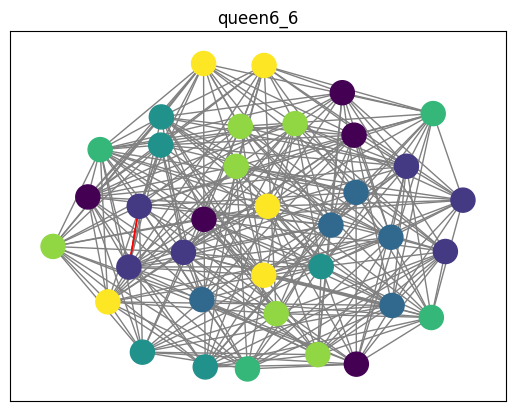

In [43]:
# Plot the colored graph
bad_edges = get_bad_edges(best_coloring, edge_list)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])


In [53]:
bad_edges

{(20, 5): 'red', (5, 20): 'red'}

In [91]:
dfresults[dfresults.dropout==0.1].groupby(['input_dim', 'hidden_dim']).mean()

dropout  use_embedding  ...      lr  collisions
input_dim hidden_dim                          ...                    
4         4               0.1            0.5  ...  0.0111   31.416667
          8               0.1            0.5  ...  0.0111   16.750000
          16              0.1            0.5  ...  0.0111    9.625000
          32              0.1            0.5  ...  0.0111    7.333333
          64              0.1            0.5  ...  0.0111    6.250000
          128             0.1            0.5  ...  0.0111    5.583333
8         4               0.1            0.5  ...  0.0111   37.125000
          8               0.1            0.5  ...  0.0111   10.666667
          16              0.1            0.5  ...  0.0111    7.375000
          32              0.1            0.5  ...  0.0111   16.791667
          64              0.1            0.5  ...  0.0111    5.666667
          128             0.1            0.5  ...  0.0111    3.583333
16        4               0.1            0.5  ...  0.0111   48.458333
          8               0.1            0.5  ...  0.0111   20.708333
          16              0.1            0.5  ...  0.0111   11.750000
          32              0.1            0.5  ...  0.0111   15.875000
          64              0.1            0.5  ...  0.0111   12.583333
          128             0.1            0.5  ...  0.0111    3.750000
32        4               0.1            0.5  ...  0.0111   57.083333
          8               0.1            0.5  ...  0.0111   34.125000
          16              0.1            0.5  ...  0.0111   13.875000
          32              0.1            0.5  ...  0.0111    6.666667
          64              0.1            0.5  ...  0.0111   17.375000
          128             0.1            0.5  ...  0.0111    6.541667
64        4               0.1            0.5  ...  0.0111   66.666667
          8               0.1            0.5  ...  0.0111   33.958333
          16              0.1            0.5  ...  0.0111   29.750000
          32              0.1            0.5  ...  0.0111   22.666667
          64              0.1            0.5  ...  0.0111   18.041667
          128             0.1            0.5  ...  0.0111   23.708333
128       4               0.1            0.5  ...  0.0111   65.666667
          8               0.1            0.5  ...  0.0111   42.541667
          16              0.1            0.5  ...  0.0111   30.166667
          32              0.1            0.5  ...  0.0111   29.625000
          64              0.1            0.5  ...  0.0111   18.416667
          128             0.1            0.5  ...  0.0111   12.333333

[36 rows x 5 columns]

In [107]:
dfresults[dfresults.collisions==1][['lr', 'input_dim', 'hidden_dim']].value_counts()

lr      input_dim  hidden_dim
0.0010  128        128           3
0.0050  64         64            2
0.0005  16         64            2
0.0001  4          128           1
0.0010  16         64            1
0.0100  32         32            1
        16         128           1
0.0050  64         32            1
        16         128           1
                   64            1
                   32            1
        8          64            1
0.0010  128        64            1
        64         16            1
        32         32            1
        16         128           1
        8          128           1
0.0001  16         128           1
0.0010  8          32            1
0.0005  128        128           1
                   32            1
        64         128           1
        32         128           1
                   8             1
        16         128           1
                   32            1
        4          128           1
0.0001  64         128   

In [49]:
# lr should be [5e-3, 1e-3, 5e-4], dropout 0.1, 0.2, 0.3 want to go from medium sized input layer to larger hidden layer

# (in_dim, hidden_dim, dropout)
# Going to focus on the (16, 128, .2) without embedding and cases without embedding and the (16, 64, 0.2/0.3) case with embedding (no alternating)

# So we will have 3*1 + 3*2 = 9 cases to test for each graph. Might expand later


0.0